# Bonus exercises

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset

# Define the device and data repository
device = 'cpu'
data_dir = 'data/'

### Exercise 1: MLP vs CNN

<img src="https://miro.medium.com/max/700/1*1Cw9nKcdKV5YQun-e4F8gQ.png" />
<center><a href="https://towardsdatascience.com/simple-introduction-to-convolutional-neural-networks-cdf8d3077bac">Source</a></center>

In lab 2 we have defined an MLP classifier, and in lab 3 we used a CNN classifier. A natural question is: how do they compare, and which one is the best? The goal of this exercise is to answer this question, in terms of number of parameters, training behavior, and accuracy on the test set.

In [2]:
# Load the Fashion MNIST dataset
train_data = datasets.FashionMNIST(data_dir, train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.FashionMNIST(data_dir, train=False, download=True, transform=transforms.ToTensor())
num_classes = len(train_data.classes)

train_data = Subset(train_data, torch.arange(500))
test_data = Subset(test_data, torch.arange(50))

# Create dataloaders
batch_size = 8
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [3]:
# TO DO: write the MLP and CNN (with batch norm) classifiers modules (you can reuse your code)

# MLP classifier
class MLPClassif(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, act_fn):
        super(MLPClassif, self).__init__()
        
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, output_size)
        self.activation_fn = act_fn
    
    def forward(self, x):
        
        h = self.layer1(x)
        h = self.activation_fn(h)
        h = self.layer2(h)
        y = self.activation_fn(h)
        
        return y
    

# CNN classifier
class CNNClassif_bnorm(nn.Module):
    def __init__(self, num_channels1=16, num_channels2=32, num_classes=10):
        super(CNNClassif_bnorm, self).__init__()
        
        self.cnn_layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2))
            
        self.cnn_layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2))
        
        self.lin_layer = nn.Linear(7*7*32, num_classes)
        
    def forward(self, x):
        
        out = self.cnn_layer1(x)
        out = self.cnn_layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.lin_layer(out)
        
        return out 


In [4]:
# TO DO: write the training function.
# No need to write 1 function for each module, you can use the same but be careful about vectorization.

# Training function
def training_classifier(model, train_dataloader, num_epochs, loss_fn, learning_rate, is_mlp=True, device='cpu', verbose=True):

    # Set the model
    model = model.to(device)
    model.train()
    
    # define the optimizer (SGD)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    # Initialize a list to save the training loss over epochs
    loss_total = []
    
    # Training loop
    for epoch in range(num_epochs):
        loss_current_epoch = 0
        for batch_index, (images, labels) in enumerate(train_dataloader):
            
            # vectorize images (MLP only)
            if is_mlp:
                images = images.reshape(images.shape[0], -1)
            
            # copy images and labels to the device
            images = images.to(device)
            labels = labels.to(device)

            # forward pass
            y_predicted = model(images)
            loss = loss_fn(y_predicted, labels)

            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Record the loss
            loss_current_epoch += loss.item()

        # At the end of each epoch, save the average loss over batches and display it
        loss_total.append(loss_current_epoch)
        if verbose:
            print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss_current_epoch))
        
    return model, loss_total

In [5]:
# TO DO: write the evaluation function (again, no need to write 2)

def eval_classifier(model, eval_dataloader, is_mlp=True, device='cpu', verbose=True):

    # Prepare the model (copy to device and disable some layers (batch norm, dropout...) when evaluating
    model.to(device)
    model.eval() 

    # In test phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        # initialize the total and correct number of labels to compute the accuracy
        correct = 0
        total = 0
        for images, labels in eval_dataloader:
            if is_mlp:
                images = images.reshape(images.shape[0], -1).to(device)
            images = images.to(device)
            labels = labels.to(device)
            y_predicted = model(images)
            _, label_predicted = torch.max(y_predicted.data, 1)
            total += labels.size(0)
            correct += (label_predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    
    return accuracy

In [6]:
# TO DO: For each model (MLP and CNN):
# - Define the parameters of the network
# - Instantiate the model
# - Train it (use the same optimizer, loss function and number of epochs for both)
# - Compute accuracy on the test set.

# Common parameters
num_classes = 10
num_epochs = 20
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.01

# MLP
input_size_mlp = train_data[0][0][0].shape[0]*train_data[0][0][0].shape[1]
hidden_size_mlp = 100
model_mlp = MLPClassif(input_size_mlp, hidden_size_mlp, num_classes, nn.Sigmoid())
model_mlp, loss_total_mlp = training_classifier(model_mlp, train_dataloader, num_epochs, loss_fn, learning_rate, is_mlp=True, device=device, verbose=True)
accuracy_mlp = eval_classifier(model_mlp, test_dataloader, is_mlp=True, device=device, verbose=True)

# CNN
num_channels1 = 16
num_channels2 = 32
model_cnn = CNNClassif_bnorm(num_channels1, num_channels2, num_classes)
model_cnn, loss_total_cnn = training_classifier(model_cnn, train_dataloader, num_epochs, loss_fn, learning_rate, is_mlp=False, device=device, verbose=True)
accuracy_cnn = eval_classifier(model_cnn, test_dataloader, is_mlp=False, device=device, verbose=True)

Epoch [1/20], Loss: 145.1036
Epoch [2/20], Loss: 144.9614
Epoch [3/20], Loss: 144.7607
Epoch [4/20], Loss: 144.5635
Epoch [5/20], Loss: 144.3765
Epoch [6/20], Loss: 144.2261
Epoch [7/20], Loss: 144.0685
Epoch [8/20], Loss: 143.8943
Epoch [9/20], Loss: 143.7087
Epoch [10/20], Loss: 143.5264
Epoch [11/20], Loss: 143.3393
Epoch [12/20], Loss: 143.1736
Epoch [13/20], Loss: 142.9660
Epoch [14/20], Loss: 142.7912
Epoch [15/20], Loss: 142.5954
Epoch [16/20], Loss: 142.3963
Epoch [17/20], Loss: 142.2076
Epoch [18/20], Loss: 141.9378
Epoch [19/20], Loss: 141.7246
Epoch [20/20], Loss: 141.5034
Epoch [1/20], Loss: 95.2880
Epoch [2/20], Loss: 39.2696
Epoch [3/20], Loss: 23.1412
Epoch [4/20], Loss: 15.9258
Epoch [5/20], Loss: 7.2640
Epoch [6/20], Loss: 3.7136
Epoch [7/20], Loss: 2.1442
Epoch [8/20], Loss: 1.3039
Epoch [9/20], Loss: 0.8888
Epoch [10/20], Loss: 0.7873
Epoch [11/20], Loss: 0.6028
Epoch [12/20], Loss: 0.5126
Epoch [13/20], Loss: 0.4428
Epoch [14/20], Loss: 0.4096
Epoch [15/20], Loss: 0

Total number of parameters
   MLP model : 79510
   CNN model : 29034


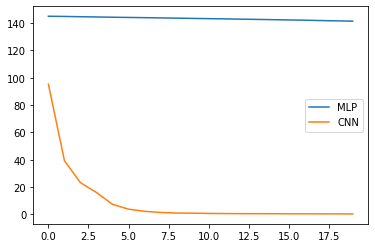

Accuracy of the network on the test images
   MLP :  40.0 %
   CNN :  74.0 %


In [7]:
# TO DO: compare the MLP and CNN models
# - print the number of parameters of each model
# - plot the training loss
# - display accuracy

print('Total number of parameters')
print('   MLP model :', sum(p.numel() for p in model_mlp.parameters()))
print('   CNN model :', sum(p.numel() for p in model_cnn.parameters()))

plt.plot(loss_total_mlp)
plt.plot(loss_total_cnn)
plt.legend(['MLP', 'CNN'])
plt.show()

print('Accuracy of the network on the test images')
print('   MLP : ', accuracy_mlp, '%')
print('   CNN : ', accuracy_cnn, '%')

### Exercise 2: CNN autoencoder

<img src="https://miro.medium.com/max/772/1*ztZn098tDQsnD5J6v1eNuQ.png" />
<center><a href="https://emkademy.medium.com/1-first-step-to-generative-deep-learning-with-autoencoders-22bd41e56d18">Source</a></center>

In lab 2.3 we have defined an MLP autoencoder. Here, we propose to do the same using CNNs. CNN autoencoders are very used in image processing applications such as image denoising, compression, and generative models (image synthesis and transformation). They can also be used for transfer learning: first an autoencoder is trained to learn a latent representation of images, and then this representation can be used for other classification/regression tasks.

In [8]:
# TO DO: create the autoencoder module (write the __init__ and forward methods)

# The encoder consists of two layers, with a convolution function, a RELU and a max pooling:
# ------ 1st layer -----
# convolution: 16 output channels, kernel_size=3, padding=1
# MaxPooling: kernel_size=2, stride=2
# ------ 2nd layer -----
# convolution: 4 output channels, kernel_size=3, padding=1
# MaxPooling: kernel_size=2, stride=2

# Then, the decoder has the same structure "in reverse" using transposed convolutions and RELU (no maxpooling):
# ------ 1st layer -----
# transposed convolution: 16 output channels, kernel_size=2, stride=2
# ------ 2nd layer -----
# transposed convolution: 1 output channel, kernel_size=2, stride=2

class CNNAutoencoder(nn.Module):
    def __init__(self):
        super(CNNAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 4, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 16, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2),
            nn.Tanh()
        )
    
    def forward(self, x):
        z = self.encoder(x)
        x_est = self.decoder(z)
        return x_est

In [9]:
# TO DO: create the training function. It should resemble other training functions you have coded,
# but here you should use the Adam optimizer instead of SGD, see: https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam

# Training function
def train_cnn_autoencoder(model, train_dataloader, num_epochs, loss_fn, learning_rate, device, verbose=True):

    # Set the model
    model = model.to(device)
    model.train()
    
    # define the optimizer (here, let's use ADAM for a change)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Initialize a list to save the training loss over epochs
    loss_all_epochs = []
    
    # Training loop
    for epoch in range(num_epochs):
        loss_current_epoch = 0
        
        # Iterate over batches (here we don't need labels
        for batch_index, (images, _) in enumerate(train_dataloader):
            
            images = images.to(device)
            
            # forward pass
            images_predicted = model(images)
            loss = loss_fn(images_predicted, images)

            # backward pass
            optimizer.zero_grad()
            loss.backward()
            loss_current_epoch += loss.item()
            optimizer.step()

        # At the end of each epoch, save the average loss over batches and display it
        loss_all_epochs.append(loss_current_epoch)
        if verbose:
            print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss_current_epoch))
        
    return model, loss_all_epochs

In [10]:
# TO DO: Write the eval function (same as the MLP autoencoder, but without vectorization)

def eval_cnn_autoencoder(model, eval_dataloader, loss_fn, device):

    # Prepare the model (copy to device and disable some layers (batch norm, dropout...) when evaluating
    model.to(device)
    model.eval() 
    losses = []
    # In test phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        # initialize the total and correct number of labels to compute the accuracy
        correct = 0
        total = 0
        for images, _ in eval_dataloader:
            images = images.to(device)
            images_predicted = model(images)
            loss = loss_fn(images_predicted, images)
            losses.append(loss.item())
            
    av_loss = np.mean(losses)
    
    return av_loss

In [11]:
# TO DO:
# - instantiate the CNN autoencoder model
# - define the optimize parameters: 100 epochs, MSE loss function, learning_rate=0.001
# - train the model and evaluate it on the test set

model_cnn_ae = CNNAutoencoder()

num_epochs = 100
loss_fn = nn.MSELoss()
learning_rate = 0.001
model_cnn_ae, loss_total = train_cnn_autoencoder(model_cnn_ae, train_dataloader, num_epochs, loss_fn, learning_rate, device)

av_loss = eval_cnn_autoencoder(model_cnn_ae, test_dataloader, loss_fn, device)
print('MSE on the test images: ', av_loss)

Epoch [1/100], Loss: 20.8751
Epoch [2/100], Loss: 4.3725
Epoch [3/100], Loss: 3.0910
Epoch [4/100], Loss: 2.8573
Epoch [5/100], Loss: 2.5379
Epoch [6/100], Loss: 2.2597
Epoch [7/100], Loss: 2.0477
Epoch [8/100], Loss: 1.8711
Epoch [9/100], Loss: 1.7311
Epoch [10/100], Loss: 1.6366
Epoch [11/100], Loss: 1.5698
Epoch [12/100], Loss: 1.5102
Epoch [13/100], Loss: 1.4559
Epoch [14/100], Loss: 1.4061
Epoch [15/100], Loss: 1.3649
Epoch [16/100], Loss: 1.3328
Epoch [17/100], Loss: 1.3063
Epoch [18/100], Loss: 1.2855
Epoch [19/100], Loss: 1.2604
Epoch [20/100], Loss: 1.2392
Epoch [21/100], Loss: 1.2221
Epoch [22/100], Loss: 1.2050
Epoch [23/100], Loss: 1.1822
Epoch [24/100], Loss: 1.1657
Epoch [25/100], Loss: 1.1491
Epoch [26/100], Loss: 1.1302
Epoch [27/100], Loss: 1.1144
Epoch [28/100], Loss: 1.1017
Epoch [29/100], Loss: 1.0913
Epoch [30/100], Loss: 1.0801
Epoch [31/100], Loss: 1.0696
Epoch [32/100], Loss: 1.0595
Epoch [33/100], Loss: 1.0489
Epoch [34/100], Loss: 1.0384
Epoch [35/100], Loss: 

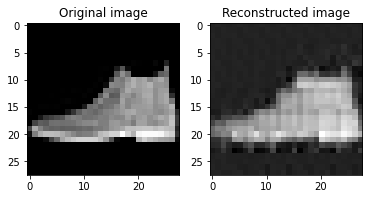

In [12]:
# TO DO: Vizualization of an example
# - load an image from the test dataset
# - pass it to the CNN autoencoder
# - plot the original and reconstructed images

# Load an image
image_example = test_data[0][0]
image_example_np = image_example.numpy().squeeze()
image_example_batch = image_example.unsqueeze(0)

# Pass it to the autoencoder
reconstructed_example = model_cnn_ae(image_example_batch.to(device))
reconstructed_example_np = reconstructed_example.detach().cpu().numpy().squeeze()

# Plot both
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(image_example_np, cmap='gray')
plt.title('Original image')
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_example_np, cmap='gray')
plt.title('Reconstructed image')
plt.show()